# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import datetime
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

print("libraries imported..")

libraries imported..


In [195]:
portfolio = pd.read_json('data/portfolio.json', orient='records',lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
print("data loaded successfully..")

data loaded successfully..


### Portfolio Data

In [196]:
portfolio.tail()

,channels,difficulty,duration,id,offer_type,reward
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [197]:
portfolio.shape
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [198]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [199]:
portfolio['offer_type'].count()


10

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:1518: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 6129 but corresponding boolean dimension is 2
  stat_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:1518: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 8484 but corresponding boolean dimension is 2
  stat_data = remove_na(group_data[hue_mask])


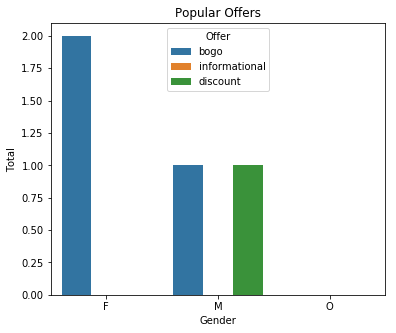

In [200]:
plt.figure(figsize=(6, 5))
sns.countplot(x=profile.gender, hue=portfolio.offer_type)
plt.title('Popular Offers')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
plt.show();

sns.countplot(transcript[transcript['offer_type'] != 'NA']['offer_type'])
plt.title('Number of Completed Promotion for Type Offer')
plt.ylabel('Number of transactions')
plt.xlabel('Offer Type')
plt.xticks(rotation = 50)
plt.show();

We can see there are three offer type provided by starbuck

In [201]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

There are no any nun values in this data set.

In [202]:
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

We can see there are basically 4 channels for posting offer to customer.

In [203]:
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [204]:

for index, row in portfolio.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in portfolio.loc[index, 'channels']:
            portfolio.loc[index, channel] = 1
        else:
            portfolio.loc[index, channel] = 0
portfolio.drop(columns='channels', inplace=True)

In [205]:
#Encode categorical features one hot coding

for index, row in portfolio.iterrows():
    for offertype in ['bogo', 'informational', 'discount']:
        if offertype in portfolio.loc[index, 'offer_type']:
            portfolio.loc[index, offertype] = 1
        else:
            portfolio.loc[index, offertype] = 0
portfolio.drop(columns='offer_type', inplace=True)

In [207]:
portfolio.duplicated().sum()

0

### Profile Data

In [208]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [209]:
profile.shape
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [210]:
profile.isnull().sum(0)

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [116]:
profile['gender'].fillna('NA', inplace=True)
profile['income'].fillna((profile['income'].mean()), inplace=True)

In [211]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

It seems gender and income column has 2175 null value

In [212]:
#finding unique customer
len(profile['id'].unique())

17000

In [213]:
#finding value gender wise
profile['gender'].value_counts().sort_values(ascending=False)

M    8484
F    6129
O     212
Name: gender, dtype: int64

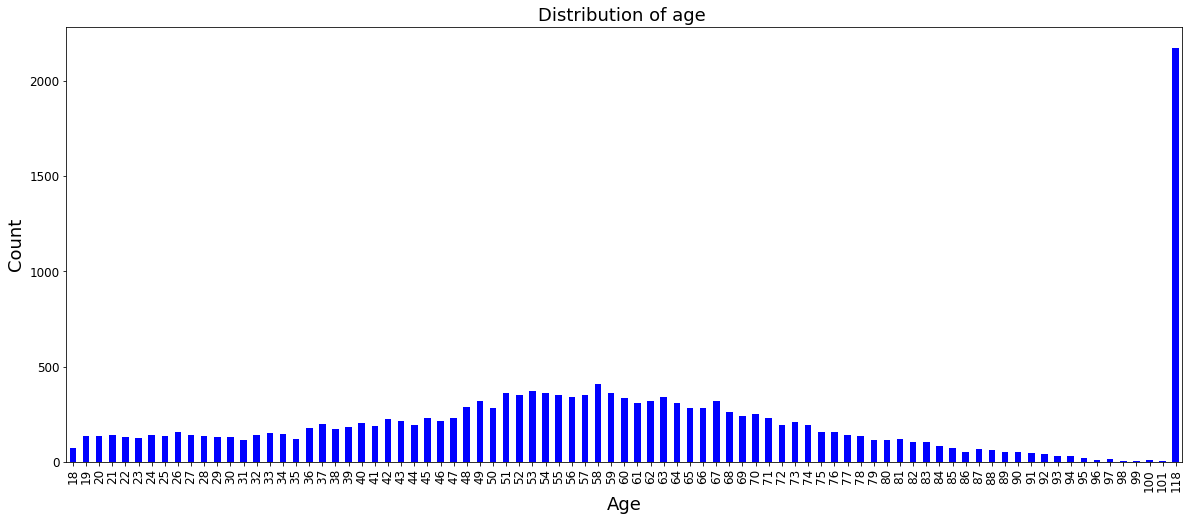

In [214]:
# Plot distribution of ages in profile dataframe 
profile['age'].value_counts().sort_index(ascending=True).plot.bar(figsize=(20,8), fontsize=12,color='blue');
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Distribution of age ', fontsize=18)
plt.show()

In [215]:
profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")

In [216]:
len(profile[profile['gender'].isnull()].index)

2175

In [217]:
profile = profile.drop(profile[profile['gender'].isnull()].index)

In [218]:
profile['gender'] = profile['gender'].apply(lambda x: 1 if x == 'M' else 0)

Seems age group 118 has NaN for income and None for gender

In [219]:
profile['start_year'] = profile.became_member_on.dt.year
profile["start_month"] = profile.became_member_on.dt.month

In [241]:
profile.rename(columns={'id': 'customer_id'}, inplace=True)
profile.head()

,age,became_member_on,gender,customer_id,income,start_year,start_month,became_member_on_month
1,55,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,2017-0
3,75,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,2017-0
5,68,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,2018-0
8,65,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,2018-0
12,58,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,2017-1


In [242]:
transcript.head()

,event,customer_id,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [222]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [223]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

We can see that there is no null value in this data

## Cleaning Data

In [243]:
profile.head()

,age,became_member_on,gender,customer_id,income,start_year,start_month,became_member_on_month
1,55,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,2017-0
3,75,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,2017-0
5,68,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,2018-0
8,65,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,2018-0
12,58,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,2017-1


Text(0.5,0,'Income')

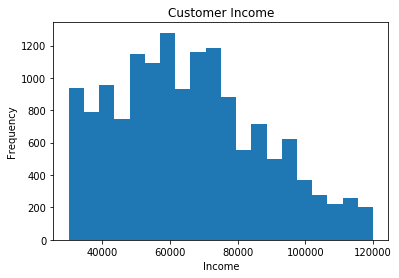

In [225]:
plt.figure()
income = profile['income'].plot(kind='hist', bins=20, title='Customer Income')
income.set_xlabel("Income")

In [244]:
profile.describe()

,age,gender,income,start_year,start_month
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,0.572277,65404.991568,2016.620169,6.695582
std,17.383705,0.494765,21598.299410,1.198245,3.488853
min,18.000000,0.000000,30000.000000,2013.000000,1.000000
25%,42.000000,0.000000,49000.000000,2016.000000,4.000000
50%,55.000000,1.000000,64000.000000,2017.000000,7.000000
75%,66.000000,1.000000,80000.000000,2017.000000,10.000000
max,101.000000,1.000000,120000.000000,2018.000000,12.000000


## Data Modeling

We try to answer following questions from our dataset.
1. average income of customer?
2. average age of customer?
3. the most common way for adverstiment and promotion?


In [227]:
#average income of customer?
profile['income'].mean()

65404.991568296799

In [228]:
#average age of customer?
profile['age'].mean()

54.393524451939292

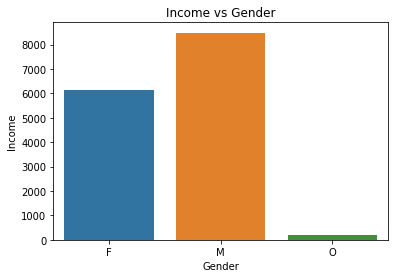

In [130]:
sns.countplot(x=profile[profile['gender'] != 'NA']['gender'])
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();


### Machine Learning Model

In [240]:
profile.head()

,age,became_member_on,gender,id,income,start_year,start_month,became_member_on_month
1,55,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,2017-0
3,75,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,2017-0
5,68,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,2018-0
8,65,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,2018-0
12,58,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,2017-1


In [230]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [231]:
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [232]:

profile['became_member_on_month'] = profile['became_member_on'].astype(str).str[:6]

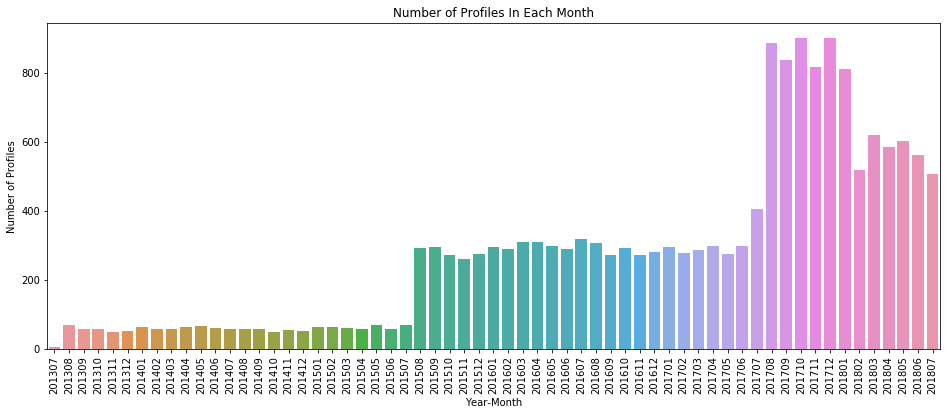

In [40]:
plt.figure(figsize=(16, 6))
sns.countplot(profile['became_member_on_month'])
plt.title('Number of Profiles In Each Month')
plt.ylabel('Number of Profiles')
plt.xlabel('Year-Month')
plt.xticks(rotation = 90)
plt.show();

We can see that end of year 2017 and first quarter of 2018 there were more customer|

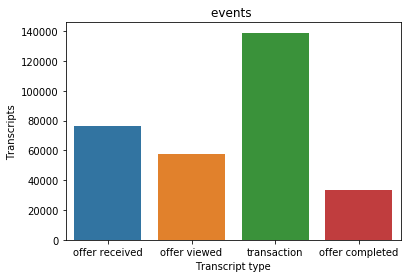

In [233]:
sns.countplot(transcript['event'])
plt.title('events ')
plt.ylabel('Transcripts')
plt.xlabel('Transcript type')
plt.xticks(rotation = 0)
plt.show();

In [235]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [236]:
transcript[transcript['person']=='0009655768c64bdeb2e877511632db8f']

,event,person,time,value
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16}
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
168412,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57}
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [ ]:

# transcript: create separate columns for amount and offer_id from value col.

def create_offer_id_col(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_col(val):
    if list(val.keys())[0] in ['amount']:
        return list(val.values())[0]
    
transcript['offer_id'] = transcript.value.apply(create_offer_id_col)
transcript['amount'] = transcript.value.apply(create_amount_col)

# change amount column type to float
transcript.amount.astype('float')

# drop value column
transcript.drop(columns=['value'], inplace=True)

In [246]:
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [247]:

transcript['time'] /= 24.0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [248]:
transcript.duplicated().sum()

374

In [249]:
transcript.drop_duplicates(inplace=True)

transcript.reset_index(drop=True, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [250]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272388 entries, 0 to 272387
Data columns (total 5 columns):
event          272388 non-null object
customer_id    272388 non-null object
time           272388 non-null float64
offer_id       148431 non-null object
amount         123957 non-null float64
dtypes: float64(2), object(3)
memory usage: 10.4+ MB


In [252]:
transaction_df = transcript[transcript.event=='transaction'].copy()
transaction_df.drop(columns=['offer_id', 'event'], inplace=True)
transaction_df.head()

,customer_id,time,amount
11027,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
11030,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
11032,54890f68699049c2a04d415abc25e717,0.0,13.23
11040,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
11041,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [253]:
offers_df = transcript[transcript.event!='transaction'].copy()

# one-hot encode offer event
offers_df['received'] = offers_df.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_df['completed'] = offers_df.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_df['viewed'] = offers_df.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

offers_df.drop(columns=['event', 'amount'], inplace=True)

In [254]:

transcript.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

In [255]:
offers_df.viewed.sum(), offers_df.completed.sum(), offers_df.received.sum()

(49860, 32070, 66501)

In [256]:
offers_df.head()

,customer_id,time,offer_id,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0


In [258]:
#event type
event_counts = transcript['event'].value_counts()
event_counts

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

In [259]:
import progressbar

In [260]:
def combine_data(profile, portfolio, offers_df, transaction_df):
    data = []
    customer_ids = offers_df['customer_id'].unique()
    
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    # loop through all customer ids in offers_df
    for ind in progressbar.progressbar(range(len(customer_ids)), widgets=widgets):
        
        # get customer id from the list
        cust_id = customer_ids[ind]
        
        # extract customer profile from profile data
        customer = profile[profile['customer_id']==cust_id]
        
        # extract offers associated with the customer from offers_df
        cust_offer_data = offers_df[offers_df['customer_id']==cust_id]
        
        # extract transactions associated with the customer from transactions_df
        cust_transaction_data = transaction_df[transaction_df['customer_id']==cust_id]
        
        # extract received, completed, viewed offer data from customer offers
        offer_received_data = cust_offer_data[cust_offer_data['received'] == 1]
        offer_completed_data = cust_offer_data[cust_offer_data['completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['viewed'] == 1]
        
        rows = []
        # loop through each received offer
        for i in range(offer_received_data.shape[0]):
            
            # fetch an offer id 
            offer_id = offer_received_data.iloc[i]['offer_id']
            
            # extract offer row from portfolio
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration_days = offer_row['duration'].values[0]
            
            # initialize start and end time of an offer
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration_days
        
            # seggregate offers completed within end date
            off_completed_withintime = np.logical_and(
                offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
            
            # seggregate offers viewed within end date
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)

            # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            
            # extract transactions occured within time
            transaction_withintime = np.logical_and(
                cust_transaction_data['time'] >= start_time, cust_transaction_data['time'] <= end_time)
        
            transaction_data = cust_transaction_data[transaction_withintime]
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        data.extend(rows)
    
    data = pd.DataFrame(data)
    return data

In [261]:
data = combine_data(profile, portfolio, offers_df, transaction_df)

 [Elapsed Time: 0:13:59] |##################################| (Time:  0:13:59) 


In [262]:
data.offer_successful.value_counts()

0    35136
1    31365
Name: offer_successful, dtype: int64

In [263]:
columns_list = ['time', 'offer_id', 'customer_id', 'total_amount', 
                'offer_successful', 'difficulty', 'duration', 
                'reward', 'bogo', 'discount', 'informational',
                'email', 'mobile', 'social', 'web', 'became_member_on',
                'gender', 'income', 'age', 'start_year', 'start_month']
data[columns_list]

,time,offer_id,customer_id,total_amount,offer_successful,difficulty,duration,reward,bogo,discount,...,email,mobile,social,web,became_member_on,gender,income,age,start_year,start_month
0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,37.67,1,5,7,5,1.0,0.0,...,1.0,1.0,0.0,1.0,2017-05-09,0,100000.0,75,2017,5
1,7.0,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,49.39,0,0,3,0,0.0,0.0,...,1.0,1.0,1.0,0.0,2017-05-09,0,100000.0,75,2017,5
2,17.0,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,48.28,1,10,7,10,1.0,0.0,...,1.0,1.0,1.0,0.0,2017-05-09,0,100000.0,75,2017,5
3,21.0,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,48.28,1,5,5,5,1.0,0.0,...,1.0,1.0,1.0,1.0,2017-05-09,0,100000.0,75,2017,5
4,0.0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.00,0,10,7,2,0.0,1.0,...,1.0,1.0,0.0,1.0,2018-04-26,1,70000.0,68,2018,4
5,14.0,3f207df678b143eea3cee63160fa8bed,e2127556f4f64592b11af22de27a7932,0.00,0,0,4,0,0.0,0.0,...,1.0,1.0,0.0,1.0,2018-04-26,1,70000.0,68,2018,4
6,17.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,18.42,1,5,7,5,1.0,0.0,...,1.0,1.0,0.0,1.0,2018-04-26,1,70000.0,68,2018,4
7,21.0,fafdcd668e3743c1bb461111dcafc2a4,e2127556f4f64592b11af22de27a7932,18.42,1,10,10,2,0.0,1.0,...,1.0,1.0,1.0,1.0,2018-04-26,1,70000.0,68,2018,4
8,0.0,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,9.54,1,5,5,5,1.0,0.0,...,1.0,1.0,1.0,1.0,2018-02-09,1,53000.0,65,2018,2
9,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,389bc3fa690240e798340f5a15918d5c,0.00,0,5,7,5,1.0,0.0,...,1.0,1.0,0.0,1.0,2018-02-09,1,53000.0,65,2018,2


In [264]:
data.to_csv('main.csv', index=False)


In [265]:
data = pd.read_csv('main.csv')


In [267]:
features = data.drop(columns=['offer_successful'])

# label variable to predict
label = data.filter(['offer_successful'])

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size=0.3, random_state=42)

# train-data: extract offer_id, total_amount and convert other features to float 
offer_id_train = X_train[:, 0]
total_amount_train = X_train[:, 1]
X_train = X_train[:, 2:]

# test-data: extract offer_id, total_amount and convert other features to float 
offer_id_test = X_test[:, 0]
total_amount_test = X_test[:, 1]
X_test = X_test[:, 2:]

# convert train and test labels to array
y_train = y_train.ravel()
y_test = y_test.ravel()

In [276]:
import re
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [270]:
naive_predictor_accuracy = accuracy_score(y_train, np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.471
Naive predictor f1-score: 0.640


In [271]:
#logistic regression

In [273]:
def evaluate_model_performance(clf, X_train, y_train):
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score
